In [ ]:
import argparse
from image_caption_integration import final_image_caption
from templateSelection import getMemeTemplate
from find_audio import main


In [ ]:
image=
model_image_caption=
word_map=
beam_size=
model_audio_mapper=
embedding=
model_meme_template=
captionsFilePath=

In [ ]:
caption = final_image_caption(image,model_image_caption,word_map,beam_size)

meme_template = getMemeTemplate(caption,model_meme_template,captionsFilePath)


In [5]:
import re
class WordPunctTokenizer:
    """WordPunctuation tokenizer."""



    def tokenize( text):
        return re.compile(r"[<\w'>]+|[^\w\s]+").findall(text)

In [6]:
SPECIAL_TOKENS = {
    'PAD': '<pad>',
    'UNK': '<unk>',
    'BOS': '<bos>',
    'EOS': '<eos>',
    'SEP': '<sep>',
    'EMPTY': '<emp>',
}


In [7]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE:', DEVICE)

DEVICE: cpu


In [8]:
def load_and_build_model(gdrive_id, ckpt_path, model_class):
    print('Downloading model weights from Google Drive')
    download_from_gdrive(gdrive_id, ckpt_path)
    clear_output()
    print('Downloaded model weights')

    print(f'Building {model_class.__name__} model')
    model = model_class.from_pretrained(ckpt_path).to(DEVICE)
    print(f'Built and loaded {model_class.__name__} model from {ckpt_path}')


    return model

In [9]:
import pickle

In [26]:
from caption_generator import CaptioningLSTM, CaptioningLSTMWithLabels,BeamSearchHelper,LabelEncoder,ImageEncoder,seq_to_text,split_caption,split_caption,memeify_image,Vocab,WordPunctTokenizer

FILE_TO_CLASS = {
    "CaptioningLSTM": CaptioningLSTM,

    "CaptioningLSTMWithLabels": CaptioningLSTMWithLabels,

}
import os
import sys




GDRIVE_ID = '1S4QwcuznRxLlxkIT0Lb6vIuqDTib41B3'
FILE_IDS_NAME = 'file_ids.txt'

download_from_gdrive(GDRIVE_ID, FILE_IDS_NAME)

FILE_IDS = {}
with open(FILE_IDS_NAME, 'r') as f:
    for line in f:
        name, gid = line.strip().split('\t')
        FILE_IDS[name] = gid

clear_output()
ckpt_path = 'LSTMDecoderWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS["CaptioningLSTM"]
model_without_label = load_and_build_model(gdrive_id, ckpt_path, model_class)
ckpt_path = 'LSTMDecoderWithLabelsWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS["CaptioningLSTMWithLabels"]
model_with_label = load_and_build_model(gdrive_id, ckpt_path, model_class)
fname = 'vocab.zip'
download_from_gdrive(FILE_IDS[fname], fname)
!unzip -o {fname}
vocab_words = Vocab.load('vocab/vocab_words.txt')
vocab_chars = Vocab.load('vocab/vocab_chars.txt')


vocabulary = vocab_words
vocab_stoi = pickle.load( open( "token_words_stoi.pickle", "rb" ) )




Downloaded model weights
Building CaptioningLSTMWithLabels model
Built and loaded CaptioningLSTMWithLabels model from LSTMDecoderWithLabelsWords.best.pth
--2020-11-19 05:06:25--  https://docs.google.com/uc?export=download&confirm=&id=1qpAv6S5c2IsKYKDdy09u8hj063qOeKT9
Resolving docs.google.com (docs.google.com)... 172.217.218.139, 172.217.218.138, 172.217.218.102, ...
Connecting to docs.google.com (docs.google.com)|172.217.218.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-24-docs.googleusercontent.com/docs/securesc/ocvp8gkpahqosb1fvo0nsdeasbs9vm6v/cnah0v2n34lc1vc8a43587ldmvu3m8le/1605762375000/02360790207211054431/18046539509261663701Z/1qpAv6S5c2IsKYKDdy09u8hj063qOeKT9?e=download [following]
--2020-11-19 05:06:26--  https://doc-14-24-docs.googleusercontent.com/docs/securesc/ocvp8gkpahqosb1fvo0nsdeasbs9vm6v/cnah0v2n34lc1vc8a43587ldmvu3m8le/1605762375000/02360790207211054431/18046539509261663701Z/1qpAv6S5c2IsKYKDdy09u8hj063qO

In [11]:
meme_caption=" "

In [48]:
def get_a_meme(model, img_torch, img_pil, caption, T=1., beam_size=7, top_k=50,labels = None, mode = 'word'):

    if model == "withoutlabels":
      model=model_without_label
    else:
      model=model_with_label
    delimiter=' '
    max_len = 32


    model.eval()
    print(caption)
    if caption is not None:

        # tokenize


        tokens = re.compile(r"[<\w'>]+|[^\w\s]+").findall(caption)

        # replace with `UNK`
        tokens = [tok if tok in vocab_stoi else SPECIAL_TOKENS['UNK'] for tok in tokens]

        # add `EOS`
        tokens += [SPECIAL_TOKENS['EOS']]

        # convert to ids
        tokens = [vocab_stoi[tok] for tok in tokens]


        caption_tensor = torch.tensor(tokens[:-1]).unsqueeze(0).to(DEVICE)
    else:
        caption_tensor = None

    if labels is None:
        with torch.no_grad():
            output_seq = model.generate(
                image=img_torch, caption=caption_tensor,
                max_len=max_len, beam_size=beam_size, temperature=T, top_k=top_k
            )
    else:
        with torch.no_grad():
            output_seq = model.generate(
                image=img_torch, label=labels, caption=caption_tensor,
                max_len=max_len, beam_size=beam_size, temperature=T, top_k=top_k
            )

    pred_seq = output_seq
    text = seq_to_text(pred_seq, vocab=vocabulary, delimiter=delimiter)
    meme_caption= text
    top, bottom = split_caption(text, num_blocks=2)
    # print(top)
    # print(bottom)

    return memeify_image(img_pil, top, bottom, font_path="/content/impact.tff")

In [39]:
DATA_DIR = 'memes900k'
CAPTIONS_FILE = os.path.join(DATA_DIR, 'captions_train.txt')

In [40]:
print('Loading the dataset from Google Drive')
fname = f'{DATA_DIR}.zip'
download_from_gdrive(FILE_IDS[fname], fname)
!unzip -o {DATA_DIR}
clear_output()

https://drive.google.com/file/d/1JTfhjhHVForkOroGYCQ_FN46bOYRlWze/view


Link for datasets_words_images_dill.pkl

In [15]:
download_from_gdrive('1JTfhjhHVForkOroGYCQ_FN46bOYRlWze',"datasets_words_images_dill.pkl")

--2020-11-19 05:01:30--  https://docs.google.com/uc?export=download&confirm=2ZyI&id=1JTfhjhHVForkOroGYCQ_FN46bOYRlWze
Resolving docs.google.com (docs.google.com)... 172.217.218.101, 172.217.218.102, 172.217.218.100, ...
Connecting to docs.google.com (docs.google.com)|172.217.218.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-00-docs.googleusercontent.com/docs/securesc/dtecb58hrt1b5phu7snvgfb9r7j488pl/3nsjle1243nkfcmu5b8sugb8thldh0i8/1605762075000/02529434781373886802/12945381378929000449Z/1JTfhjhHVForkOroGYCQ_FN46bOYRlWze?e=download [following]
--2020-11-19 05:01:30--  https://doc-14-00-docs.googleusercontent.com/docs/securesc/dtecb58hrt1b5phu7snvgfb9r7j488pl/3nsjle1243nkfcmu5b8sugb8thldh0i8/1605762075000/02529434781373886802/12945381378929000449Z/1JTfhjhHVForkOroGYCQ_FN46bOYRlWze?e=download
Resolving doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Conne

In [16]:
import dill
templates = dill.load(open( "datasets_words_templates_dill.pkl", "rb" ) )
images = dill.load(open( "datasets_words_images_dill.pkl", "rb" ) )

In [27]:
# Image from dataset
import torch
from PIL import Image
import re
label = meme_template
#label = "Paranoid Parrot"
tokens = re.compile(r"[<\w'>]+|[^\w\s]+").findall(label)
tokens = [tok if tok in vocab_stoi else SPECIAL_TOKENS['UNK'] for tok in tokens]
tokens += [SPECIAL_TOKENS['EOS']]
tokens = [vocab_stoi[tok] for tok in tokens]


labels = torch.tensor(tokens).unsqueeze(0)
img_torch = images[label]
img_pil = Image.open(templates[label])

img_torch = img_torch.unsqueeze(0)


In [22]:
caption="wehbf fjsf"

https://drive.google.com/file/d/1mLHoTqF5TUbFTyQBv7zaoVdU7SrW7sKq/view?usp=sharing

In [41]:
download_from_gdrive('1mLHoTqF5TUbFTyQBv7zaoVdU7SrW7sKq','impact.tff')

--2020-11-19 05:11:45--  https://docs.google.com/uc?export=download&confirm=&id=1mLHoTqF5TUbFTyQBv7zaoVdU7SrW7sKq
Resolving docs.google.com (docs.google.com)... 108.177.126.101, 108.177.126.138, 108.177.126.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4g-docs.googleusercontent.com/docs/securesc/v4384ro5q28t2i7srppdics4vaqscars/uequu89cnrg915u28vf5vah5k1v7g66b/1605762675000/04381972525381903232/00822361666954799581Z/1mLHoTqF5TUbFTyQBv7zaoVdU7SrW7sKq?e=download [following]
--2020-11-19 05:11:45--  https://doc-0k-4g-docs.googleusercontent.com/docs/securesc/v4384ro5q28t2i7srppdics4vaqscars/uequu89cnrg915u28vf5vah5k1v7g66b/1605762675000/04381972525381903232/00822361666954799581Z/1mLHoTqF5TUbFTyQBv7zaoVdU7SrW7sKq?e=download
Resolving doc-0k-4g-docs.googleusercontent.com (doc-0k-4g-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connectin

if using "withoutlabels" keep labels=None

wehbf fjsf


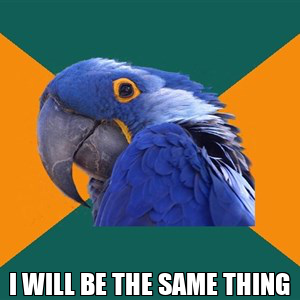

In [49]:


get_a_meme(
    model="withoutlabels", T=1.3,
    beam_size=10,
    top_k=100,
    img_torch=img_torch,
    img_pil=img_pil,
    caption=caption,
    labels=None,
    mode='word'

)

In [ ]:

audio = main(model_audio_mapper,"sentence_bert",embeddings, meme_caption)
print(audio)

In [ ]:
!pip install ffmpeg-python
!pip install ipywidgets==7.4
!pip install --upgrade IPython

In [ ]:
import ffmpeg


input_still = ffmpeg.input("Problem.jpg")
input_audio = ffmpeg.input("Problem.mpeg")

(
    ffmpeg
    .concat(input_still, input_audio, v=1, a=1)
    .output("output.mp4")
    .run(overwrite_output=True)
)

In [ ]:
from IPython.display import Video
Video('output.mp4', embed=True, html_attributes="controls autoplay")